# Quadcopter Trajectory Optimization

Let's take a look at an idealized 2D quadcopter that consists of a vehicle in 2D with two propellers (a left one and a right one). To illustrate this, let's build up some data structures.

## Data Structures (feel free to skip)

First, we'll make a `QuadcopterDynamics` class by subclassing the `FreeBodyDynamics` class. (Basically, we're making a copy here that we can tack on various methods to).

We'll add a `draw()` method here that will let us visualize what's happening.

In [73]:
import aerosandbox as asb
import aerosandbox.numpy as np
from aerosandbox.dynamics.dynamics import FreeBodyDynamics
from aerosandbox.tools.pretty_plots import plt, show_plot, mpl, adjust_lightness


class QuadcopterDynamics(FreeBodyDynamics):
    @staticmethod
    def draw_vehicle(xe, ze, theta):
        ### Draw the vehicle, normalized to have the total width be 1.
        height = 0.05
        prop_width = 0.65
        prop_AR = 0.2
        color = "#bc5eff"
        bodycolor = adjust_lightness(color, 0.2)

        vehicle_patches = [
            mpl.patches.Rectangle(  # Body
                xy=(-0.5, -height / 2),
                width=1, height=height,
                color=bodycolor
            ),
            mpl.patches.Ellipse(  # Hub
                xy=(0, height / 2),
                width=0.3, height=0.1,
                color=bodycolor
            ),
            mpl.patches.PathPatch(  # Legs
                mpl.path.Path(
                    np.array([
                        [-0.2, -0.15],
                        [-0.1, 0],
                        [0.1, 0],
                        [0.2, -0.15],
                        [0.18, -0.15],
                        [0.05, 0],
                        [-0.05, 0],
                        [-0.18, -0.15],

                    ]),
                ),
                color=bodycolor
            ),
            mpl.patches.Ellipse(  # Left propeller
                xy=(-0.5, height / 2 + 0.01),
                width=prop_width, height=prop_width * prop_AR,
                color=color,
                alpha=0.5
            ),
            mpl.patches.Ellipse(  # Right propeller
                xy=(0.5, height / 2 + 0.01),
                width=prop_width, height=prop_width * prop_AR,
                color=color,
                alpha=0.5
            )
        ]

        for patch in vehicle_patches:
            t = mpl.transforms.Affine2D()
            t.scale(0.1)  # set the right size
            t.rotate(theta - np.pi / 2)  # rotate to orient theta the right way
            t.translate(xe, -ze)

            patch.set_transform(t + plt.gca().transData)
            plt.gca().add_patch(patch)

    def draw(self, show=True):

        def make_iterable(var):
            try:
                iter(var)
                return var
            except TypeError:
                return [var] * np.length(self.time)

        for xe, ze, theta in zip(
                make_iterable(self.xe),
                make_iterable(self.ze),
                make_iterable(self.theta)
        ):
            self.draw_vehicle(
                xe=xe,
                ze=ze,
                theta=theta,
            )

        plt.plot(
            make_iterable(self.xe),
            make_iterable(-self.ze),
            zorder=2
        )

        plt.axis("equal")
        if show:
            plt.show()

Here's our quadcopter!

C:\GitHub\AeroSandbox\aerosandbox\dynamics\dynamics.py:77: UserWarning: Can't add physics constraints to your dynamics environment, since no `opti` instance was provided. Skipping...
  warnings.warn(


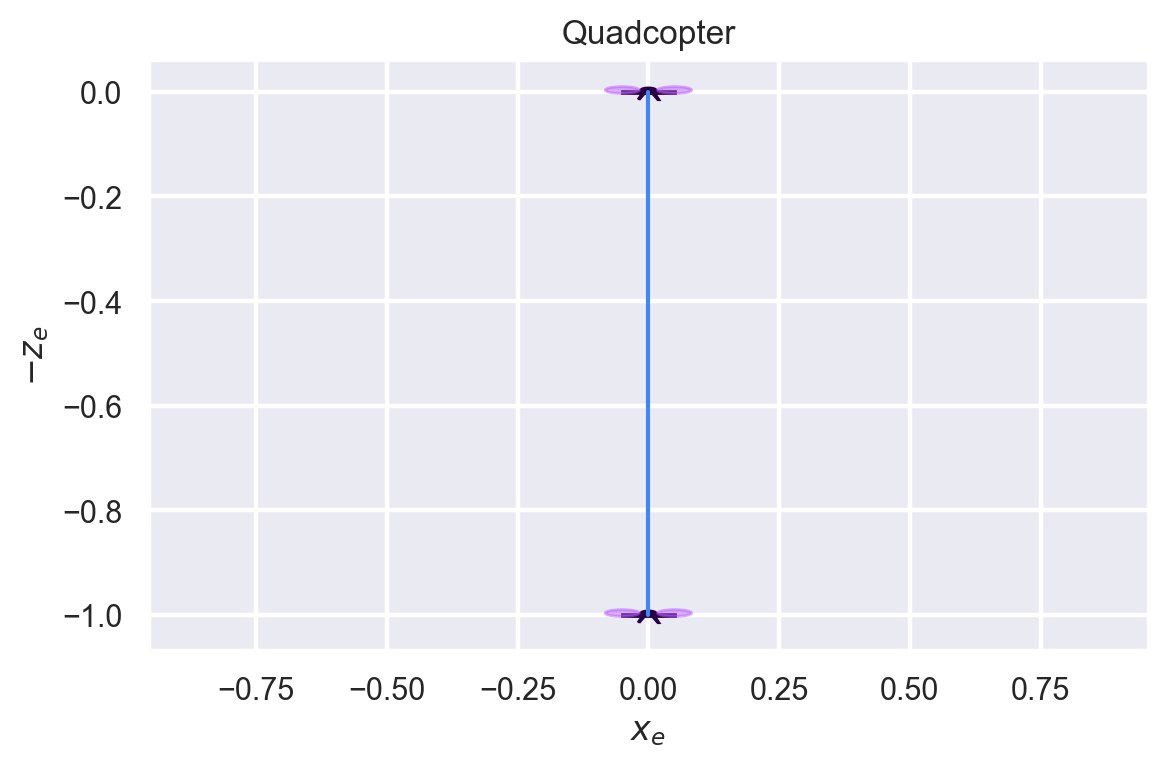

In [74]:
dyn = QuadcopterDynamics(
    time=np.array([0, 1]),
    theta=np.radians(90),
    ze=np.array([0,1])
)

dyn.draw(show=False)
show_plot(
    "Quadcopter",
    r"$x_e$",
    r"$-z_e$",
)

##